In [3]:
import zipfile as z
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

## Data prep and cleaning

In [4]:
dataframes = {}

with z.ZipFile(r"Downloads\Airbnb+Data.zip", 'r') as zip_re:
    filelist = zip_re.namelist()
    #print(filelist)
    csv_files = [f for f in filelist if f.endswith(".csv")]
    #print(csv_files)

    for csv_file in csv_files:
        # Use the full path to read the file
        with zip_re.open(csv_file) as file:
            df = pd.read_csv(file, encoding='latin1', low_memory=False)
            
            # Use just the filename (without path) as the key
            filename_only = csv_file.split("/")[-1]
            #print(filename_only)
            dataframes[filename_only] = df
            print(f"Loaded {filename_only}: {df.shape}")


Loaded Listings.csv: (279712, 33)
Loaded Listings_data_dictionary.csv: (33, 2)
Loaded Reviews.csv: (5373143, 4)
Loaded Reviews_data_dictionary.csv: (4, 2)


In [5]:
dataframes["Listings.csv"]["host_since"] = pd.to_datetime(dataframes["Listings.csv"]["host_since"])
dataframes.keys()

dict_keys(['Listings.csv', 'Listings_data_dictionary.csv', 'Reviews.csv', 'Reviews_data_dictionary.csv'])

### Data analysis and aggregation with pandas

#### We are taking portion of data to analyse specifically paris data so we can focus only on it

In [6]:
#dataframes["Listings.csv"].tail()
paris_data = (dataframes["Listings.csv"]
 .loc[dataframes["Listings.csv"]["city"] == "Paris",
 ["host_since", "neighbourhood", "city", "accommodates","price"]]
)

In [7]:
paris_data.isna().sum()

host_since       33
neighbourhood     0
city              0
accommodates      0
price             0
dtype: int64

In [8]:
paris_data.describe()

,host_since,accommodates,price
count,64657,64690.000000,64690.000000
mean,2015-11-01 11:06:05.528867584,3.037997,113.096445
min,2008-08-30 00:00:00,0.000000,0.000000
25%,2014-03-09 00:00:00,2.000000,59.000000
50%,2015-07-07 00:00:00,2.000000,80.000000
75%,2017-05-29 00:00:00,4.000000,120.000000
max,2021-02-07 00:00:00,16.000000,12000.000000
std,NaN,1.588766,214.433668


In [9]:
paris_data.loc[(paris_data["price"] == 0) | (paris_data["accommodates"] == 0)]

,host_since,neighbourhood,city,accommodates,price
98209,2020-07-20,Pantheon,Paris,0,0
203257,2020-02-04,Batignolles-Monceau,Paris,0,0
203258,2016-10-17,Opera,Paris,0,0
203259,2020-04-24,Luxembourg,Paris,0,0
203260,2020-04-24,Vaugirard,Paris,0,0
...,...,...,...,...,...
208881,2020-10-22,Pantheon,Paris,0,0
208882,2020-11-26,Enclos-St-Laurent,Paris,0,0
208883,2020-11-26,Vaugirard,Paris,0,0
208884,2020-12-21,Vaugirard,Paris,0,0


In [10]:
paris_listings_neighbourhood = (paris_data
 .groupby("neighbourhood")
 .agg({"price":"mean"})
 .sort_values("price")
)
paris_listings_neighbourhood.tail()

,price
neighbourhood,
Luxembourg,155.638639
Palais-Bourbon,156.856578
Passy,161.144635
Louvre,175.379972
Elysee,210.536765


In [11]:
paris_listings_accomodations = (paris_data
 .query("neighbourhood == 'Elysee'")
 .groupby("accommodates")
 .agg({"price":"mean"})
 .sort_values("price")
)
paris_listings_accomodations.head()

,price
accommodates,
0,0.000000
1,79.522222
3,152.828767
2,155.103352
4,212.096070


In [12]:
paris_listings_over_time = (paris_data
 .set_index("host_since")
 .resample("YE")
 .agg({"price":"mean", "neighbourhood":"count"})
)

paris_listings_over_time.head()

,price,neighbourhood
host_since,,
2008-12-31,77.750000,4
2009-12-31,159.641509,106
2010-12-31,125.031250,416
2011-12-31,124.828230,1339
2012-12-31,111.578615,4592


### Data Visulisation with pandas

#### Now we can visualise the findings below

In [13]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [14]:
plt.style.use("ggplot")

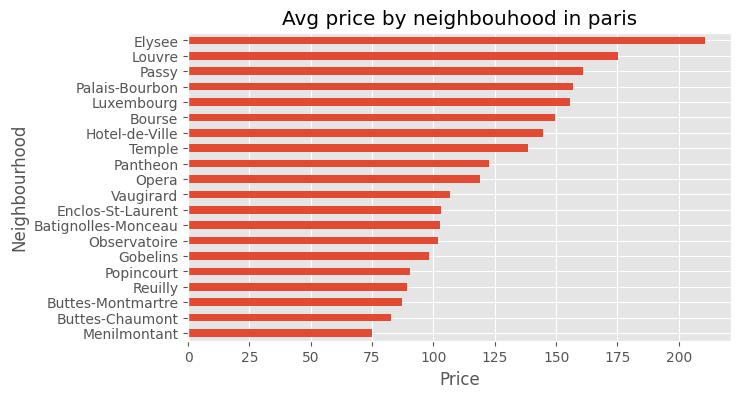

In [15]:
# avg price by neighbourhood

(paris_listings_neighbourhood.plot
 .barh(title = "Avg price by neighbouhood in paris", figsize =(7,4)
      ,xlabel="Price", ylabel="Neighbourhood"
       ,legend=False
)
);

<Axes: title={'center': 'Avg price by accomodation in paris'}, xlabel='price', ylabel='Accomodation in number'>

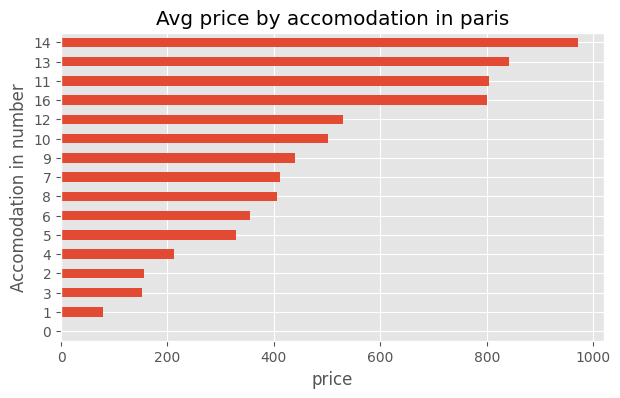

In [16]:
# avg price by accomodates 

(paris_listings_accomodations.plot
 .barh(title = "Avg price by accomodation in paris", figsize =(7,4)
    , xlabel = "price", ylabel ="Accomodation in number"
    ,legend=False
)
)

<Axes: title={'center': 'New Airbnb host in paris over time '}, xlabel='host_since', ylabel='New hosts'>

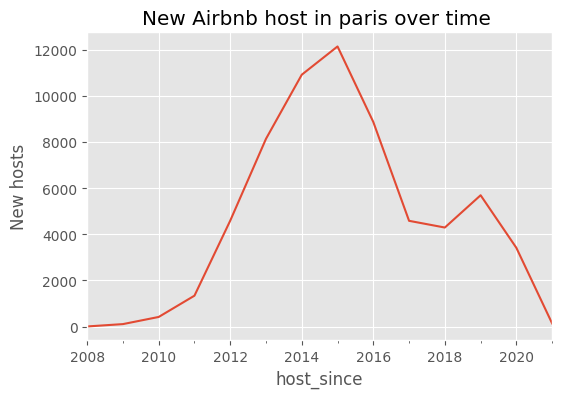

In [17]:
# new host over time

(paris_listings_over_time["neighbourhood"]
 .plot(
     title ="New Airbnb host in paris over time ",
     ylabel = 'New hosts',
     figsize=(6,4)
 )
)

<Axes: title={'center': 'Avg Aibnb price in paris over time '}, xlabel='host_since', ylabel='Avg price'>

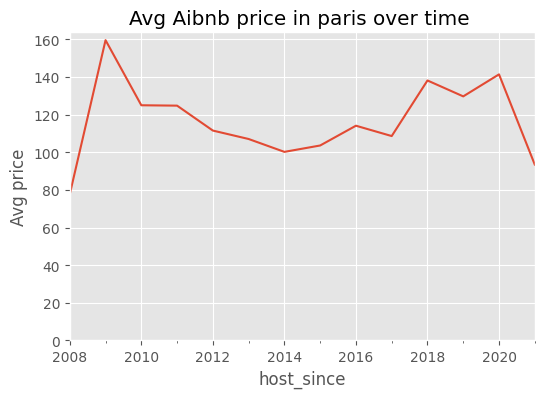

In [18]:
(paris_listings_over_time["price"]
 .plot(
     title ="Avg Aibnb price in paris over time ",
     ylabel = 'Avg price',
     figsize=(6,4),
     ylim=0
 )
)

Text(0.5, 0.98, 'Paris Airbnb trend new host vs avg price')

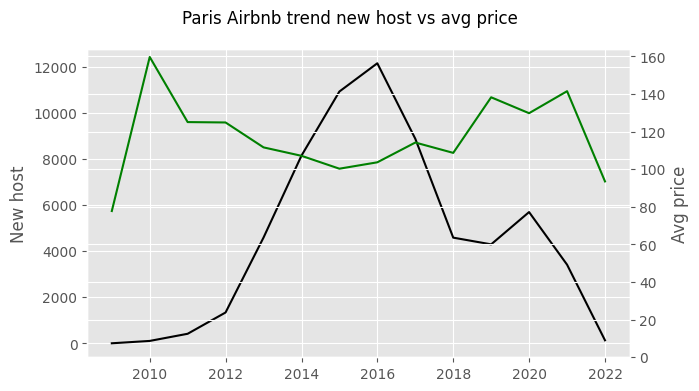

In [20]:
# creating twin axis plot

# create a canvas and main plot area

fig, ax1 = plt.subplots(figsize=(7,4))

ax1.plot(
    paris_listings_over_time.index,
    paris_listings_over_time["neighbourhood"],
    color ="black"
)
ax1.set_ylabel("New host")

ax2 = ax1.twinx()

ax2.plot(
    paris_listings_over_time.index,
    paris_listings_over_time["price"],
    color ="green",
)
ax2.set_ylim(0)
ax2.set_ylabel("Avg price")
fig.suptitle("Paris Airbnb trend new host vs avg price")